# Example of calculating a monthly mean for an area

In [2]:
import xarray as xr
xr.__version__
import rioxarray

In [3]:
import sys
sys.path.append('/home/jovyan/intake-aodn')
import intake_aodn
from  intake_aodn.easicache import set_easi
intake_aodn.cat = set_easi()
intake_aodn.cat.path

/home/jovyan/intake-aodn/intake_aodn/catalogs/aodn_refs.zip aodn_refs.zip s3://easihub-csiro-user-scratch/AROAWO7MSC2TWB77JYRIM:csiro-csiro-aad_mor582@csiro.au/aodn_refs.zip
/home/jovyan/intake-aodn/intake_aodn/catalogs/main.yaml main.yaml s3://easihub-csiro-user-scratch/AROAWO7MSC2TWB77JYRIM:csiro-csiro-aad_mor582@csiro.au/main.yaml
/home/jovyan/intake-aodn/intake_aodn/catalogs/aodn.yaml aodn.yaml s3://easihub-csiro-user-scratch/AROAWO7MSC2TWB77JYRIM:csiro-csiro-aad_mor582@csiro.au/aodn.yaml
/home/jovyan/intake-aodn/intake_aodn/catalogs/nci.yaml nci.yaml s3://easihub-csiro-user-scratch/AROAWO7MSC2TWB77JYRIM:csiro-csiro-aad_mor582@csiro.au/nci.yaml


's3://easihub-csiro-user-scratch/AROAWO7MSC2TWB77JYRIM:csiro-csiro-aad_mor582@csiro.au/main.yaml'

## Step 1 - Load and display a KML for the area of interest

In [4]:
import fiona # A library for lots of geospatial analysis
import geopandas as gpd # A library for opening shapefiles (and the like) and displaying their attribues and geometry
import matplotlib.pyplot as plt # A general purpose plotting library
import cartopy.crs as ccrs # Library for plotting maps in python
import cartopy.feature as cf # Library for plotting maps in python

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #adds support for reading KML to geopandas
gdf = gpd.read_file('SharkBay.kml', driver='KML')
gdf

,Name,Description,geometry
0,SharkBay,,"POLYGON Z ((113.61460 -24.56049 0.00000, 113.4..."


Make a quick plot of the polygon

In [5]:
type(gdf.geometry[0])

shapely.geometry.polygon.Polygon

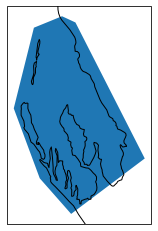

In [6]:

ax = plt.axes(projection = ccrs.PlateCarree())
gdf.plot(ax=ax)
ax.add_feature(cf.COASTLINE)

## Step 2: Create a small cluster within the machine that our notebook is running on 

The machine has 8 cores and 32GB of memory as you can see from expanding the "Cluster Info" below

In [7]:
from intake_aodn.utils import get_distributed_cluster
client = get_distributed_cluster(worker_cores=1,worker_memory=2.0, min_workers=10, max_workers=10, worker_threads=1)
client


# from intake_aodn.utils import get_local_cluster
# client = get_local_cluster(n_workers=16,threads_per_worker=16)
# client

An existing cluster was found. Connected to cluster easihub.80860376b09d42edb9fa66b4a28ea20f


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.csiro.easi-eo.solutions/services/dask-gateway/clusters/easihub.80860376b09d42edb9fa66b4a28ea20f/status,


## Step 6: Calculate the monthly mean and plot the data


In [8]:
entry=intake_aodn.cat.aodn_s3.SST_L3S_1d_ngt(startdt='1998-01-01',
                                             enddt='2021-01-02',
                                             cropto=gdf,
                                            variables =['sea_surface_temperature','quality_level'])
ds = entry.to_dask()

# # #ds = ds.load()
ds

<xarray.Dataset>
Dimensions:                  (time: 8313, latitude: 114, longitude: 84)
Coordinates:
  * latitude                 (latitude) float32 -24.49 -24.51 ... -26.73 -26.75
  * longitude                (longitude) float32 112.8 112.8 ... 114.5 114.5
  * time                     (time) datetime64[ns] 1998-01-01T15:20:00 ... 20...
Data variables:
    quality_level            (time, latitude, longitude) float32 dask.array<chunksize=(3500, 114, 84), meta=np.ndarray>
    sses_count               (time, latitude, longitude) float32 dask.array<chunksize=(3500, 114, 84), meta=np.ndarray>
    l2p_flags                (time, latitude, longitude) float32 dask.array<chunksize=(3500, 114, 84), meta=np.ndarray>
    sses_standard_deviation  (time, latitude, longitude) float32 dask.array<chunksize=(3500, 114, 84), meta=np.ndarray>
    sea_surface_temperature  (time, latitude, longitude) float32 dask.array<chunksize=(3500, 114, 84), meta=np.ndarray>
    sst_dtime                (time, latitude, longitude) float64 dask.array<chunksize=(1750, 114, 84), meta=np.ndarray>
    satellite_zenith_angle   (time, latitude, longitude) float32 dask.array<chunksize=(3500, 114, 84), meta=np.ndarray>
    sses_bias                (time, latitude, longitude) float32 dask.array<chunksize=(3500, 114, 84), meta=np.ndarray>

In [9]:
from shapely.geometry import mapping
ds =ds.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
ds.rio.write_crs("epsg:4326", inplace=True)
clipped = ds.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=False)

In [10]:
clipped

<xarray.Dataset>
Dimensions:                  (latitude: 114, longitude: 84, time: 8313)
Coordinates:
  * latitude                 (latitude) float64 -24.49 -24.51 ... -26.73 -26.75
  * longitude                (longitude) float64 112.8 112.8 ... 114.5 114.5
  * time                     (time) datetime64[ns] 1998-01-01T15:20:00 ... 20...
    spatial_ref              int64 0
Data variables:
    quality_level            (time, latitude, longitude) float32 dask.array<chunksize=(3500, 114, 84), meta=np.ndarray>
    sses_count               (time, latitude, longitude) float32 dask.array<chunksize=(3500, 114, 84), meta=np.ndarray>
    l2p_flags                (time, latitude, longitude) float32 dask.array<chunksize=(3500, 114, 84), meta=np.ndarray>
    sses_standard_deviation  (time, latitude, longitude) float32 dask.array<chunksize=(3500, 114, 84), meta=np.ndarray>
    sea_surface_temperature  (time, latitude, longitude) float32 dask.array<chunksize=(3500, 114, 84), meta=np.ndarray>
    sst_dtime                (time, latitude, longitude) float64 dask.array<chunksize=(1750, 114, 84), meta=np.ndarray>
    satellite_zenith_angle   (time, latitude, longitude) float32 dask.array<chunksize=(3500, 114, 84), meta=np.ndarray>
    sses_bias                (time, latitude, longitude) float32 dask.array<chunksize=(3500, 114, 84), meta=np.ndarray>

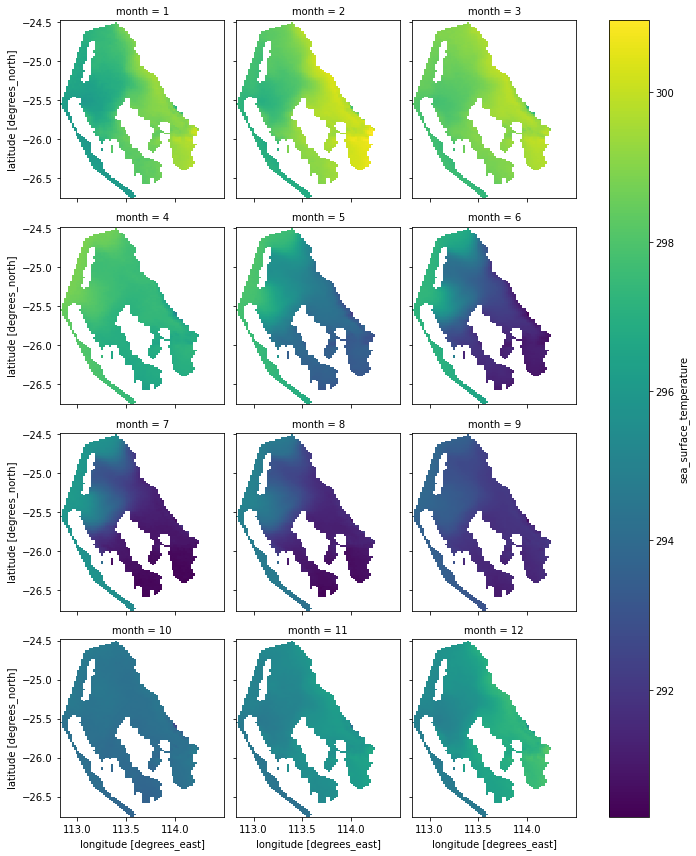

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/env/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/usr/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1131)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/env/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/env/lib/python3.8/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle_read()
  File "/env/lib/python3.8/site-packages/tornado/iostream.py", line 1478, in 

In [11]:
monthly_mean=clipped.sea_surface_temperature.groupby('time.month').mean()
monthly_mean.plot(x='longitude',y='latitude',col='month',col_wrap=3)

<xarray.Dataset>
Dimensions:                            (time: 365)
Coordinates:
    latitude                           float32 -32.01
    longitude                          float32 115.0
  * time                               (time) datetime64[ns] 2011-01-01T15:20...
Data variables:
    l2p_flags                          (time) float32 8.192e+03 nan ... nan
    quality_level                      (time) float32 5.0 nan 5.0 ... 2.0 nan
    satellite_zenith_angle             (time) float32 33.91 nan ... 16.35 nan
    sea_surface_temperature            (time) float32 295.7 nan ... 294.1 nan
    sea_surface_temperature_day_night  (time) float32 295.9 nan ... 294.5 nan
    sses_bias                          (time) float32 0.1272 nan ... -0.662 nan
    sses_count                         (time) float32 2.656 nan ... 2.165 nan
    sses_standard_deviation            (time) float32 0.476 nan ... 0.6925 nan
    sst_dtime                          (time) float64 1.105e+04 nan ... nan

2022-07-23 04:21:03,560 - distributed.client - ERROR - Failed to reconnect to scheduler after 1.00 seconds, closing client


In [9]:
monthly_mean=ds.sea_surface_temperature.groupby('time.month').mean()
monthly_mean.plot(x='longitude',y='latitude',col='month',col_wrap=3)

NameError: name 'ds' is not defined